In [46]:
import creme
import utils
import custom_model
import pandas as pd
import matplotlib.pyplot as plt

In [137]:
def plot_track(tracks, alpha=0.6, color=None, zoom=None, marks=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(1, figsize=[20, 2])
    for coverage in tracks:
        if color:
            ax.plot(coverage, c=color, alpha=alpha)
        else:
            ax.plot(coverage, alpha=alpha)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    if zoom:
        plt.xlim(zoom[0], zoom[1])
    if marks:
        ymin, ymax = ax.get_ylim()
        for mark in marks:
        
            plt.vlines(mark, 0, ymax, color='k', linestyle='--')
    plt.plot()
    return ax

# Load Enformer and example sequences

In [8]:
track_index = [5111]
model = custom_model.Enformer(track_index=track_index)
target_df = pd.read_csv(f'../data/enformer_targets_human.txt', sep='\t')
cell_line_info = {i: [t, utils.clean_cell_name(target_df.iloc[t]['description'])] for i, t in
              enumerate(track_index)}

In [122]:
fasta_path = f'../data/GRCh38.primary_assembly.genome.fa'
seq_parser = utils.SequenceParser(fasta_path)

genes = ['ABCA8_chr17_68955392_-', 'NFKBIZ_chr3_101849513_+']
gene_seqs = {}

for gene in genes:
    gene_name, chrom, start, strand = gene.split('_')
    seq = seq_parser.extract_seq_centered(chrom, int(start), strand, model.seq_length)
    gene_seqs[gene_name] = seq

In [123]:
abca8_wt = model.predict(gene_seqs['ABCA8'])[0,:,0]
nfkbiz_wt = model.predict(gene_seqs['NFKBIZ'])[0,:,0]

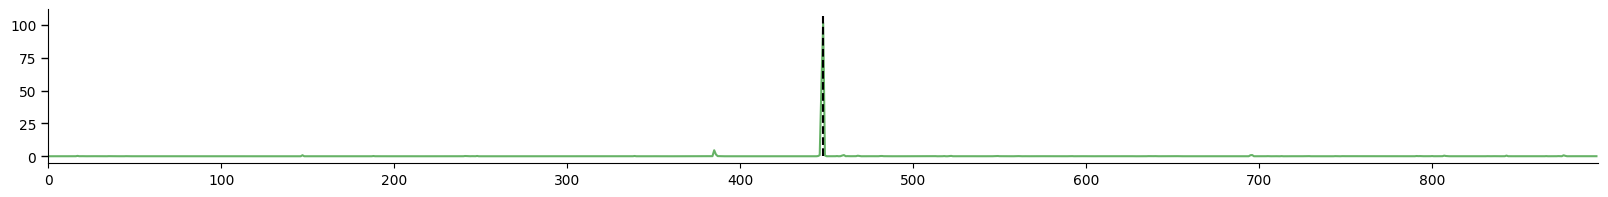

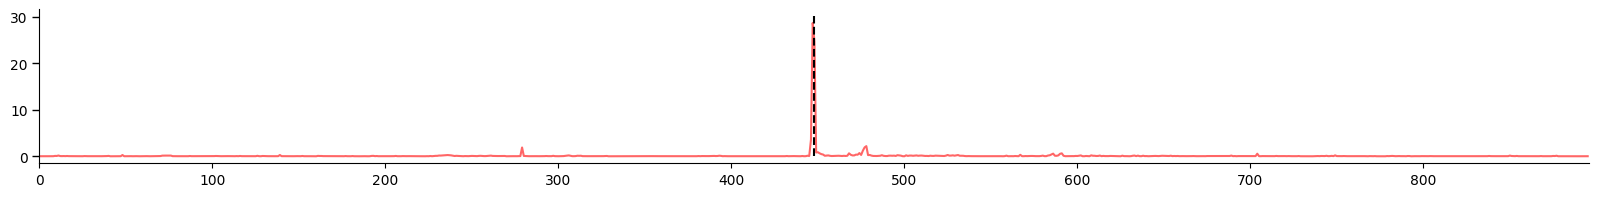

In [125]:
plot_track([abca8_wt], color='green', zoom=[0, 896], marks=[448])
plot_track([nfkbiz_wt], color='red', zoom=[0, 896], marks=[448])

# Context dependence test

In [126]:
seq_halflen = model.seq_length // 2
half_window_size = 2500
N_shuffles = 10

## Enhancing context sequence
This is an example sequence with enhancing context, where shuffling the sequence context leads to a drop in TSS activity.
To run context dependence test we need:
- a loaded model
- onehot encoded sequence (WT)
- a coordinate interval where the TSS
- number of times to run the shuffling
- optionally, we can choose if the results will be summarized or the results of each shuffle will be returned
- optionally, we can omit getting WT predictions to save time 

In [147]:
_, pred_mut = creme.context_dependence_test(model, gene_seqs['ABCA8'],
                                            [seq_halflen - half_window_size, seq_halflen + half_window_size],
                                            N_shuffles, mean=False, drop_wt=True)

<Axes: >

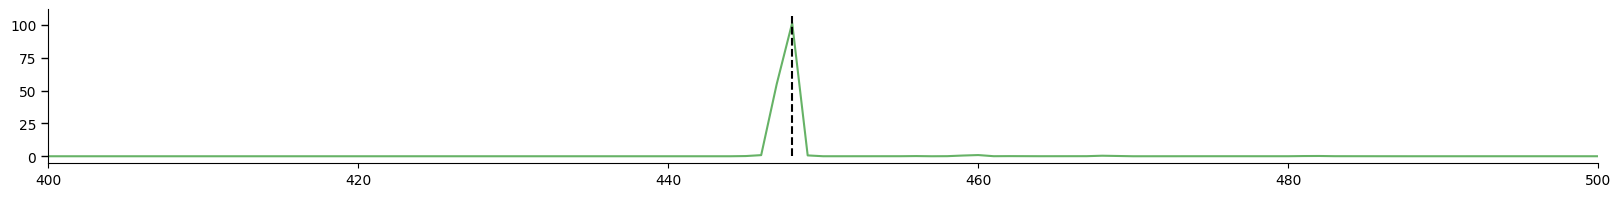

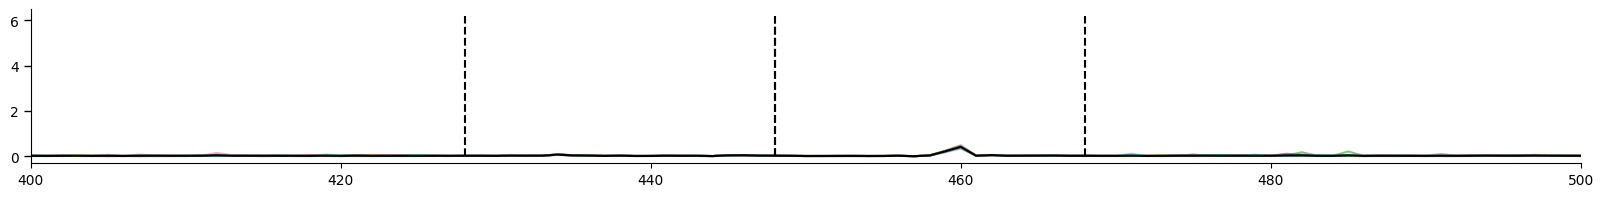

In [148]:
plot_track([abca8_wt], color='green', zoom=[400, 500], marks=[448])
ax=plot_track(pred_mut[:,:,0], zoom=[400, 500], marks=[448])
plot_track([pred_mut[:,:,0].mean(axis=0)], alpha=1, color='k', zoom=[400, 500], marks=[428, 448, 468], ax=ax)

## Silencing context sequence
This is an example sequence with silencing context, where shuffling the sequence context leads to an increase in TSS activity.

In [149]:
_, pred_mut = creme.context_dependence_test(model, gene_seqs['NFKBIZ'],
                                                            [seq_halflen - half_window_size, seq_halflen + half_window_size],
                                                            N_shuffles, mean=False, drop_wt=True)

<Axes: >

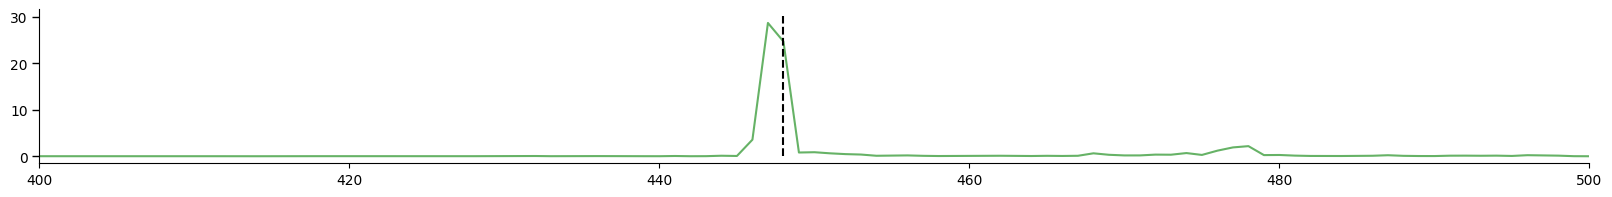

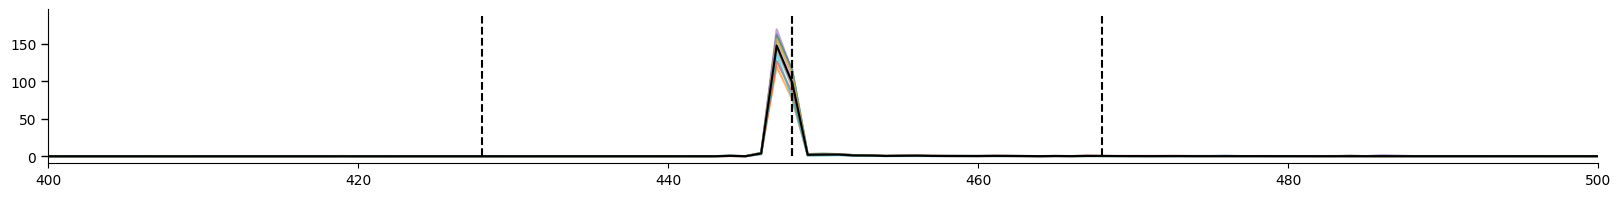

In [150]:
plot_track([nfkbiz_wt], color='green', zoom=[400, 500], marks=[448])
ax=plot_track(pred_mut[:,:,0], zoom=[400, 500], marks=[448])
plot_track([pred_mut[:,:,0].mean(axis=0)], alpha=1, color='k', zoom=[400, 500], marks=[428, 448, 468], ax=ax)